## Classification Model with Linear Model

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [3]:
import parse_inputs

from pathlib import Path

import numpy as np
import pandas as pd
from pandas_plink import read_plink

from sklearn import linear_model
from sklearn.svm import SVR
from sklearn import metrics

from ggplot import *
PATH=Path('ddat/crowdAI/')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
from sklearn.decomposition import PCA

# Data load

X is genotype and gender , y is height, get residual, and two and triple class

### Taizhao data

Mapping files: 100%|██████████| 3/3 [00:02<00:00,  1.24s/it]


all samples 2747 male 989 female 1758


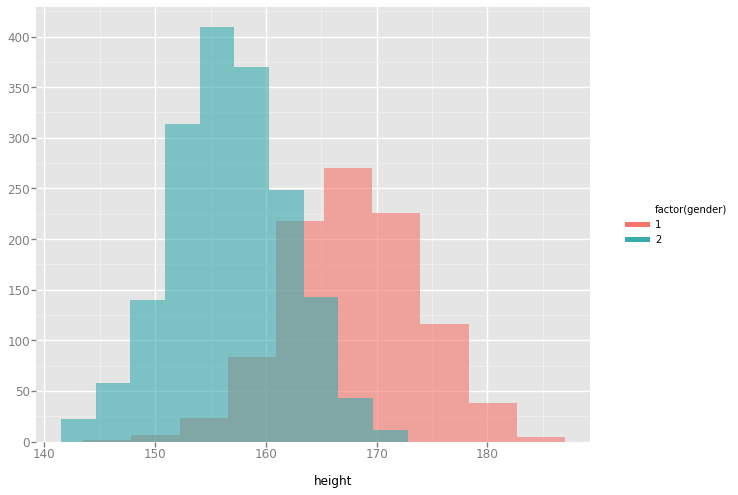

<ggplot: (-9223363260345292123)>

In [14]:
(tz_bim,tz_fam,tz_bed) = read_plink('ddat/crowdAI/all2964/bin_final_strand')
tz_f_meta = pd.read_csv(PATH/'TZ14_height_f_v2.csv')
tz_m_meta = pd.read_csv(PATH/'TZ14_height_m_v2.csv')
tz_meta = tz_m_meta.append(tz_f_meta,ignore_index=True)
print("all samples",len(tz_meta),'male',len(tz_m_meta),'female',len(tz_f_meta))
ggplot( aes(x='height',fill='factor(gender)'),data=tz_meta) +\
    geom_histogram(alpha=0.6)

### Opensnp data

Training data

Mapping files: 100%|██████████| 3/3 [00:14<00:00,  6.78s/it]


opensnp training data 783


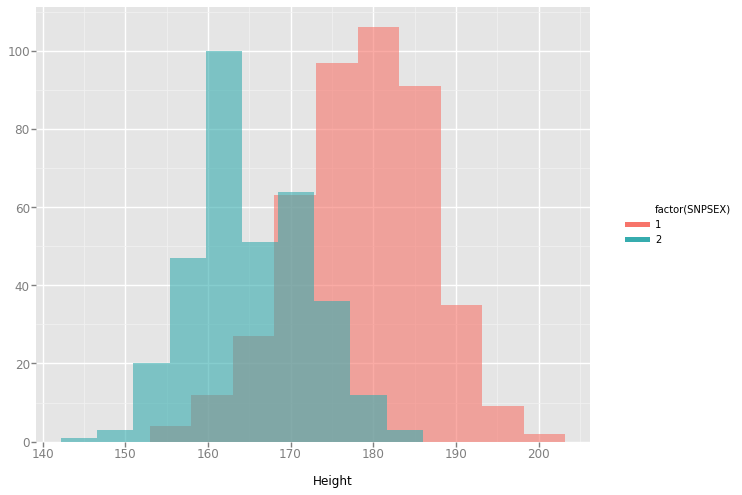

<ggplot: (8776502203028)>

In [15]:
(os_bim, os_fam, os_bed) = read_plink('ddat/crowdAI/OpenSNP_train')
os_meta = pd.read_csv(PATH/'opensnp_metadat.csv',index_col=0)
os_meta = os_meta.loc[os_meta.SNPSEX>0,]
print('opensnp training data',len(os_meta))
ggplot( aes(x='Height',fill='factor(SNPSEX)'),data=os_meta) +\
    geom_histogram(alpha=0.6)

Test data

In [16]:
os_plink_test = read_plink('ddat/crowdAI/OpenSNP_test')
os_meta_test = pd.read_csv(PATH/'opensnp_trianandtest_metadata.csv',index_col=0)
os_meta_test=os_meta_test.loc[[int(x) for x in list(os_plink_test[1].iid)]]
#check iid and gender
#sum(os_meta_test.IID.eq([int(x) for x in list(os_plink_test[1].iid)])),len(os_meta_test)
#sum(os_meta_test.SNPSEX>0),sum(os_meta_test.SNPSEX.isna())
print('opensnp test data',len(os_meta_test),'male',sum(os_meta_test.SNPSEX==1))

Mapping files: 100%|██████████| 3/3 [00:14<00:00,  6.63s/it]

opensnp test data 137 male 78


In [17]:
os_meta_test['height']=0
os_meta_test=os_meta_test.iloc[:,[1,7,0,4,3]]
os_meta_test.columns=['ID','height','ChipID','nationality','gender']
os_meta_test.index = list([str(x) for x in os_meta_test.ChipID])
os_meta_test = os_meta_test.loc[[x for x in list(os_plink_test[1].iid) if x in os_meta_test.index]]
os_meta_test['nationality']=pd.Series(list((os_meta_test.nationality=='PROBLEM').astype(np.int)),index=os_meta_test.index)
os_meta_test.head()

,ID,height,ChipID,nationality,gender
11,11,0,11,1,1
12,12,0,12,1,2
14,14,0,14,1,1
35,35,0,35,1,1
43,43,0,43,1,2


In [9]:
os_meta_test.to_csv(TMP_PATH/'os_meta_test.csv')

# Data Cleaning 

### Meta data integration

In [10]:
new_os_meta=os_meta.iloc[:,[1,7,0,4,3]]
tz_meta=tz_meta.iloc[:,0:5]
new_os_meta.columns=tz_meta.columns

In [11]:
def y_boolean(x,m,f,g):
    if g==1:
        return int(x>m)
    elif g==2:
        return int(x>f)
    else:
        print('error')
        
def half_percent(m):
    y=m.height
    m50 = np.percentile(y.loc[list(m.gender==1)],50)
    f50 = np.percentile(y.loc[list(m.gender==2)],50)
    yb= [y_boolean(x,m50,f50,m.gender.iloc[i]) for i,x in enumerate(y)]
    return yb

In [12]:
def y_triple(x,mh,ml,fh,fl,g):
    if g==1:
        if x>mh:
            return 1
        elif x<ml:
            return -1
        else:
            return 0
    elif g==2:
        if x>fh:
            return 1
        elif x<fl:
            return -1
        else:
            return 0
    else:
        print('error')
def triple_percent(X):
    y = X.height
    m25 = np.percentile(y.loc[list(X.gender==1)],25)
    f25 = np.percentile(y.loc[list(X.gender==2)],25)
    m75 = np.percentile(y.loc[list(X.gender==1)],75)
    f75 = np.percentile(y.loc[list(X.gender==2)],75)
    yt= [y_triple(x,m75,m25,f75,f25,X.gender.iloc[i]) for i,x in enumerate(y)]
    return yt

In [13]:
tz_meta['biclass']=half_percent(tz_meta)
new_os_meta['biclass']=half_percent(new_os_meta)

tz_meta['triclass']=triple_percent(tz_meta)
new_os_meta['triclass']=triple_percent(new_os_meta)

/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


all train and val samples 3530 tz 2747 os 783 male 1435


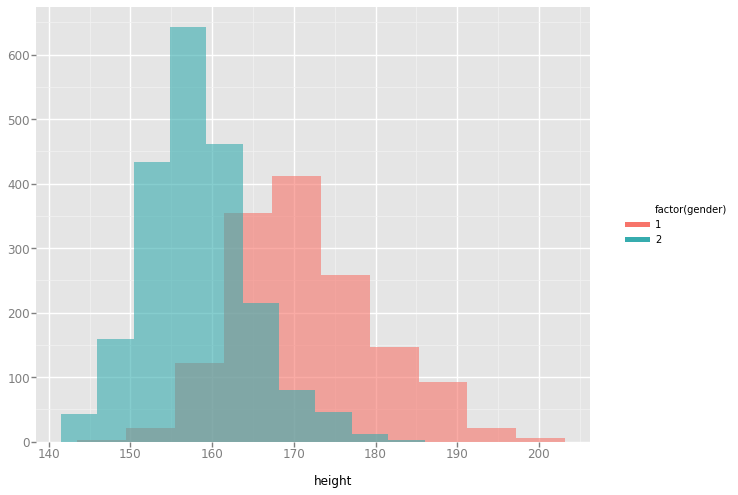

<ggplot: (-9223363278926683588)>

In [17]:
all_meta = tz_meta.append(new_os_meta,ignore_index=True)
print('all train and val samples',len(all_meta),'tz',len(tz_meta),'os',len(new_os_meta),'male',sum(all_meta.gender==1))

ggplot( aes(x='height',fill='factor(gender)'),data=all_meta) +\
    geom_histogram(alpha=0.6)

In [18]:
all_meta.index = list([str(x) for x in all_meta.ChipID])
all_meta = all_meta.loc[[x for x in list(tz_fam.iid)+list(os_fam.iid) if x in all_meta.index]]
all_meta['nationality']=pd.Series(list((all_meta.nationality=='PROBLEM').astype(np.int)),index=all_meta.index)
all_meta.tail()

,ID,height,ChipID,nationality,gender,biclass,triclass
917,917,171.0,917,1,1,0,-1
918,918,176.0,918,1,1,0,0
919,919,165.1,919,1,1,0,-1
920,920,172.0,920,1,2,1,1
921,921,175.0,921,1,1,0,0


## Linear Model

In [18]:
from sklearn import linear_model
import crowdai

### Linear model (gender and nationality)

In [19]:
all_meta = pd.read_csv(TMP_PATH/'tz_and_os_meta.csv',index_col=0)

In [20]:
#Load training data
x_train = all_meta[['gender','nationality']]
y_train = all_meta.height
x_test = os_meta_test[['gender','nationality']]

# Instantiate a linear model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 13d33303-9340-4f05-a757-8db2f3edb9a1


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 13d33303-9340-4f05-a757-8db2f3edb9a1


100% |██████████|[00:00<00:00]  102.34% /s] 


CrowdAI.Event.Job.INFO : (13d33303-9340-4f05-a757-8db2f3edb9a1) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.418981198924 ; MSE : 59.0634560883
CrowdAI.Event.Job.COMPLETE : 13d33303-9340-4f05-a757-8db2f3edb9a1	   🍺 


In [21]:
all_meta['residual']=y_train-regr.predict(x_train)

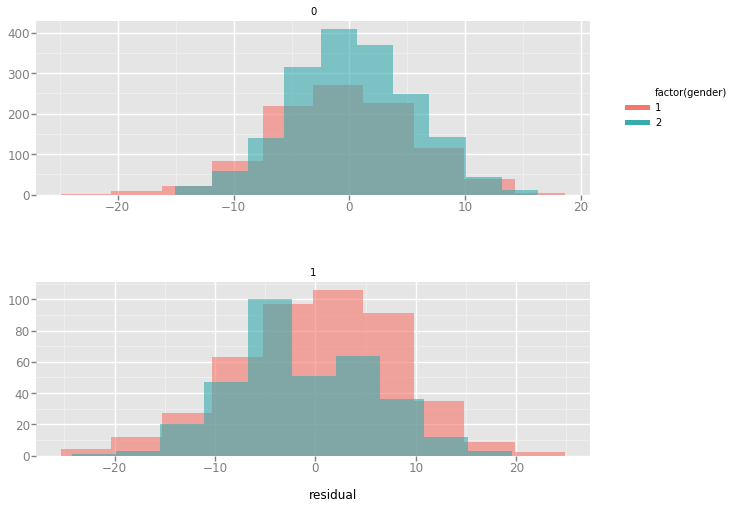

<ggplot: (8776510230220)>

In [22]:
ggplot( aes(x='residual',fill='factor(gender)'),data=all_meta) +\
    geom_histogram(alpha=0.6)+\
    facet_wrap('nationality',scales='free')

In [23]:
all_meta.pivot_table(['biclass','residual'],index=['gender', 'nationality'],aggfunc=np.sum)

biclass    residual
gender nationality                     
1      0                493 -482.228604
       1                214  482.228604
2      0                868  482.228604
       1                166 -482.228604

In [23]:
all_meta.to_csv(TMP_PATH/'tz_and_os_meta.csv')

# Get genotype  

In [2]:
!ls {TMP_PATH}

ls: cannot access '{TMP_PATH}': No such file or directory


In [24]:
snps = pd.read_csv(PATH/'snps_sorted_p_val_v2.csv')

In [25]:
snps_tz = pd.read_csv(TMP_PATH/'SNPs_GWAS_Pincrease_Residual_of_Gender.csv',index_col=0)

In [26]:
snps_hc = {}
for n in [50,100,500,1000,2000,5000,10000]:
    snp_c_idx = list(range(n))
    snps_hc[n]=set(snps.snp[snp_c_idx]).intersection(list(snps_tz.index[snp_c_idx]))
    print(len(snps_hc[n]))

4
6
19
25
52
128
281


In [27]:
all_meta.head()

,ID,height,ChipID,nationality,gender,biclass,triclass,residual
9992564090_R01C01,TL2257,177.0,9992564090_R01C01,0,1,1,1,8.606139
9992564090_R05C01,TL0067,155.0,9992564090_R05C01,0,2,0,0,-1.518641
9992564090_R07C01,TL0139,143.5,9992564090_R07C01,0,2,0,-1,-13.018641
9992564090_R08C01,TL0279,161.9,9992564090_R08C01,0,2,1,1,5.381359
9992564137_R01C01,TL1090,155.2,9992564137_R01C01,0,2,0,0,-1.318641


#### get sub snp and samples

In [28]:
def plink_slice(p,pb=None,pf=None):
    """
    p: list of bim, fam, bed
    pb: index of bim
    pf: index of fam
    """
    (bim,fam,bed)=p
    if pb:
        bim = bim.iloc[pb]
        bed = bed[pb,:]
    if pf:
        fam = fam.iloc[pf]
        bed = bed[:,pf]
    return(bim,fam,bed)

In [29]:
common_snp = set(snps_tz.index[0:1000]).intersection(*(tz_bim.snp,os_bim.snp))

In [30]:
snp_pv_idx = [i for i,x in enumerate(snps_tz.index) if x in common_snp][0:500]

In [31]:
tz_snp500_index = [i for i,x in enumerate(tz_bim.snp) if x in list(snps_tz.index[snp_pv_idx])]
tz_sample_index = [i for i,x in enumerate(tz_fam.iid) if x in list(all_meta.ChipID)]
tz_sub=plink_slice((tz_bim,tz_fam,tz_bed),tz_snp500_index,tz_sample_index)

In [32]:
os_snp500_index = [i for i,x in enumerate(os_bim.snp) if x in list(snps_tz.index[snp_pv_idx])]
os_sample_index = [i for i,x in enumerate(os_fam.iid) if x in list(all_meta.index)]
os_sub=plink_slice((os_bim,os_fam,os_bed),os_snp500_index,os_sample_index)

#### get sub test sample

In [33]:
os_sub_test=plink_slice(os_plink_test,os_snp500_index)
#check test sample and training sample having same snps
print(os_sub_test[0].shape,os_sub[0].shape)
print(os_sub_test[0].iloc[:,0:4].equals(os_sub[0].iloc[:,0:4]))
#but some of them have opposite a0 and a1
sum([x==y for x,y in zip(os_sub_test[0].a0,os_sub[0].a0)])

(500, 7) (500, 7)
True


485

## align a0 and a1 to a ref. (reverse 0 and 2 genotype)

In [34]:
def align_a0_a1(refp,p):
    refbim=refp[0].reset_index(drop=True)
    pbim=p[0].reset_index(drop=True)
    if refbim.snp.equals(pbim.snp) and refbim.pos.equals(pbim.pos):
        diff_idx=[x!=y for x,y in zip(refbim.a0,pbim.a0)]
        if all([x==y for x,y in zip(refbim.a0[diff_idx],pbim.a1[diff_idx])]):
            pbed = pd.DataFrame(p[2].compute())
            tmp = pbed.copy()
            #tmp1 = pbed.copy()
            tmp = tmp.iloc[diff_idx,:]
            #tmp1 = tmp1.iloc[diff_idx,:]
            tmp.replace([0,2],[2,0],inplace=True)
            pbed.loc[diff_idx]=tmp
            return pbed
        else:
            print("can't alignment")
    else:
        print('error happens in align')

align genotype of opensnp traing and test data to taizhao

In [35]:
os_sub_align = align_a0_a1(tz_sub,os_sub)
os_sub_test_align = align_a0_a1(tz_sub,os_sub_test)

## Merge training data from taizhou and opensnp 

In [36]:
all_bim = tz_sub[0]
all_fam = tz_sub[1].append(os_sub[1])
#row sample and column snps
all_bed_T= pd.DataFrame(tz_sub[2].compute()).T.append(os_sub_align.T)
all_bed_T.fillna(-1,inplace=True)
all_bed_T.index = list(all_fam.iid)
all_bed_T.columns=list(all_bim.snp)
all_bed_T=all_bed_T.loc[:,list(snps_tz.index[snp_pv_idx])]
all_bim.shape,all_fam.shape,all_bed_T.shape

((500, 7), (3530, 7), (3530, 500))

In [37]:
os_sub_test_align_T = os_sub_test_align.T
os_sub_test_align_T.columns = list(all_bim.snp)
os_sub_test_align_T=os_sub_test_align_T.loc[:,list(snps_tz.index[snp_pv_idx])]
#Replace nan values in the training and testing set with an arbitrary number (-1)
os_sub_test_align_T.fillna(-1,inplace=True)

In [48]:
samp_size=len(all_meta)
train_ratio = 0.8
train_size = int(samp_size * train_ratio)

import random
random.seed(1)
val_idx = random.sample(range(samp_size), samp_size-train_size)
print(samp_size,train_size)

3530 2824


In [49]:
m=linear_model.LinearRegression()
X = all_bed_T
y = all_meta
Xt = os_sub_test_align_T
yt = os_meta_test
mr = regr

(3530, 291) (137, 291)
[(2824, 291), (706, 291), (2747, 291), (783, 291), (137, 291)]
[[0.6075774549753932, 37.43631664439255], [0.6158240422180106, 41.322964766456074], [0.4714917665739973, 31.748066896809004], [0.44687555921997046, 60.89684746276911]]
0 [177.   155.   143.5  161.9  155.2  149.8  164.   167.   164.5  151.   155.   149.   157.   156.   155.
 162.   161.   155.   152.9  153.2  ... 160.02 188.   180.   183.   190.   182.88 170.   153.   182.88 183.
 195.   203.2  182.88 179.   164.   174.   176.   165.1  172.   175.  ] [168.14797 152.01429 146.90585 163.83577 151.15947 154.2375  166.27432 162.61902 168.279   153.54135
 157.7176  146.61344 156.20681 156.60999 157.78911 158.65905 160.38376 155.60288 158.35002 152.12066 ...
 166.48575 180.10619 175.28577 179.65981 174.4317  180.05456 165.73138 164.94596 179.54923 176.43529
 177.24825 181.71117 184.05605 181.88112 173.46321 179.31687 178.95023 177.57397 166.634   178.01541]
1 [158.6  165.   144.   147.2  154.2  161.   164.  

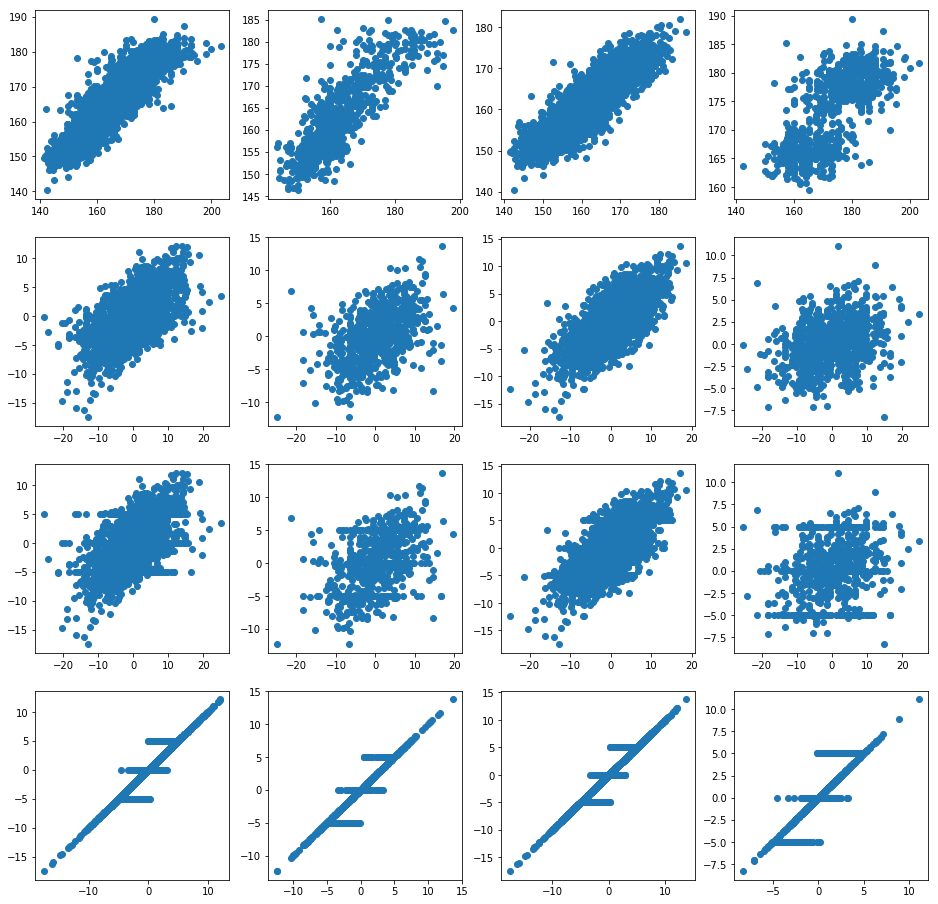

In [113]:
tmp = super_model(m,X,y,Xt,yt,val_idx,mr,pca=True)

In [77]:
def submit(x):
    challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
    challenge.submit(x.tolist())
    challenge.disconnect()

In [114]:
def model_pred(ml,dt,p=False):
    pr= []
    if p:
        for d in dt:
            pr.append(ml.predict_proba(d))
    else:
        for d in dt:
            pr.append(ml.predict(d))
    return pr

In [112]:
def super_model(m,X,y,Xt,yt,val_idx,mr,pca=True):
    #pca
    if pca:        
        pca = PCA(.95)
        X=pd.DataFrame(pca.fit_transform(X))
        Xt = pd.DataFrame(pca.transform(Xt))
        print(X.shape,Xt.shape)
    #data    
    ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, np.array(y.residual))
    ((gn_val,gn_trn),(gn_y_val,gn_y_trn)) = split_by_idx(val_idx, y[['gender','nationality']].values, np.array(y.height))
    ((yb_val,yb_trn),(yt_val,yt_trn)) = split_by_idx(val_idx,y.biclass,y.triclass)
    
    tes,gn_tes = Xt.values, yt[['gender','nationality']].values
    
    tz_idx = boo2idx(y.nationality==0)
    ((tz,os), (y_tz,y_os)) = split_by_idx(tz_idx, X.values, np.array(y.residual))
    ((gn_tz,gn_os),(gn_y_tz,gn_y_os)) = split_by_idx(tz_idx, y[['gender','nationality']].values, np.array(y.height))
    ((yb_tz,yb_os),(yt_tz,yt_os)) = split_by_idx(tz_idx,y.biclass,y.triclass)
    print([x.shape for x in [trn,val,tz,os,tes]])
    #model
    ml = m
    ml.fit(trn, y_trn)
    
    mb = linear_model.LogisticRegression()
    mb.fit(trn, yb_trn)
    
    mt = linear_model.LogisticRegression()
    mt.fit(trn, yt_trn)
    
    #
    yr = [y_trn,y_val,y_tz,y_os]
    yh = [gn_y_trn,gn_y_val,gn_y_tz,gn_y_os]
    #pred
    pbase = model_pred(mr,[gn_trn,gn_val,gn_tz,gn_os,gn_tes])
    pr = model_pred(ml,[trn,val,tz,os,tes])
    pbi = model_pred(mb,[trn,val,tz,os,tes])
    pbi_prob = model_pred(mb,[trn,val,tz,os],p=True)
    ptri =  model_pred(mt,[trn,val,tz,os,tes])
    ptri_prob = model_pred(mt,[trn,val,tz,os],p=True)
    ph = [x+y for x,y in zip(pr,pbase)]
    pr_c = [np.clip(x,-20,20) for x in pr]
    ph_c = [x+y for x,y in zip(pr_c,pbase)]
    pr_b = [biclip(x,b) for x,b in zip(pr_c,pbi)]
    ph_b = [x+y for x,y in zip(pr_b,pbase)]
    pr_t = [triclip(x,b,t) for x,b,t in zip(pr_c,pbi,ptri)]
    ph_t = [x+y for x,y in zip(pr_t,pbase)]
    
    for y,scores in zip([yb_trn,yb_val,yb_tz,yb_os],pbi_prob)
        fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
    
    print([[metrics.r2_score(x,y),metrics.mean_squared_error(x,y)] for x,y in zip(yh,pbase[:-1])])
    tmp = [[[metrics.r2_score(x,y),metrics.mean_squared_error(x,y)] for x,y in zip(yr+yh,t)] 
           for t in [pr[:-1]+ph[:-1],pr_c[:-1]+ph_c[:-1],pr_b[:-1]+ph_b[:-1],pr_t[:-1]+ph_t[:-1]]]
    
    f, axs = plt.subplots(4, 4,figsize=(16, 16))
    axs = axs.ravel()
    for i,x,y in zip(list(range(16)),yh+yr+yr+pr[:-1],ph[:-1]+pr[:-1]+pr_t[:-1]+pr_t[:-1]):
        print(i,x,y)
        axs[i].scatter(x,y,marker='o')
    axs[14].auc
    axs[15].auc
    plt.show()

    [submit(pbase[4] + x[4])for x in [pr,pr_c,pr_b,pr_t]]
    
    return tmp

In [109]:
list(range(16))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

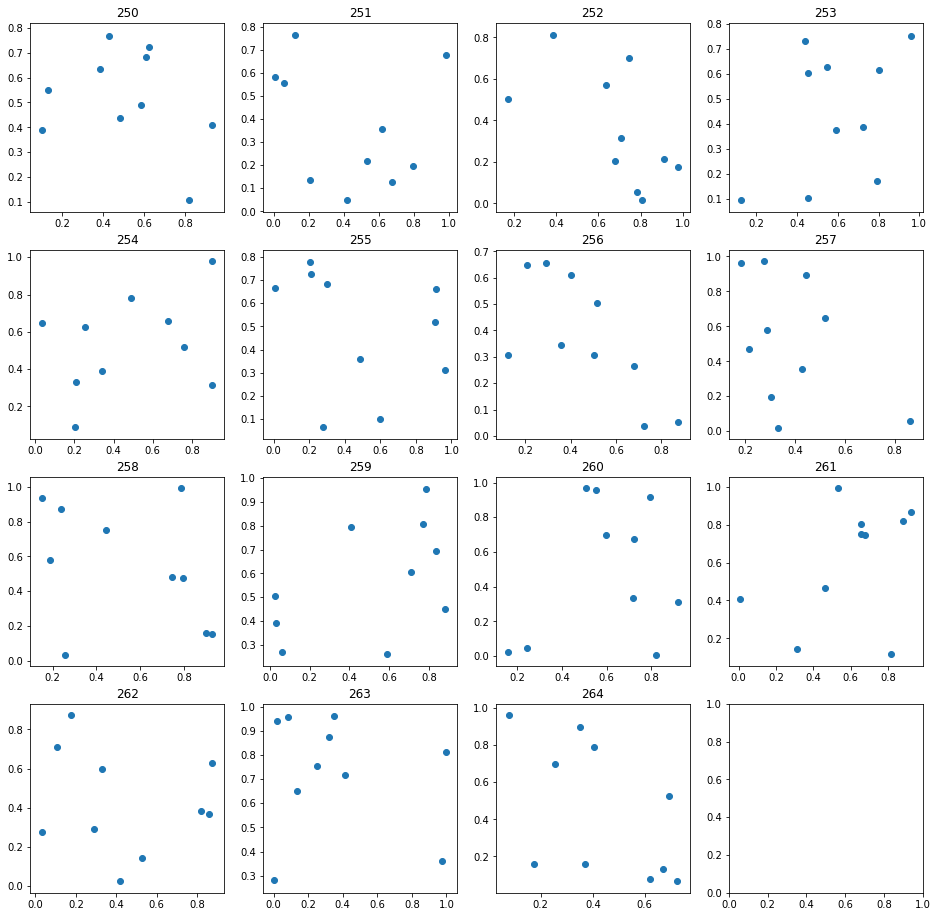

In [103]:
fig, axs = plt.subplots(4,4,figsize=(16, 16))
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(15):

    axs[i].scatter(np.random.rand(10),np.random.rand(10))
    axs[i].set_title(str(250+i))

In [84]:
def test():
    ph_test = mr.predict(yt[['gender','nationality']].values)+biclip(np.clip(ml.predict(Xt.iloc[:,var_idx]),-20,20),mb.predict(Xt.iloc[:,var_idx]),mt.predict(Xt.iloc[:,var_idx]))

    #model


    pr_trn = ml.predict(trn)
    ph_trn = mr.predict(gn_trn)+pr_trn
    pr_val = ml.predict(val)
    ph_val = mr.predict(gn_val)+pr_val
    pr_tz = ml.predict(tz)
    ph_tz = mr.predict(gn_tz)+pr_tz
    pr_os = ml.predict(os)
    ph_os = mr.predict(gn_os)+pr_os
    pr_tes = ml.predict(tes)
    ph_tes = mr.predict(gn_tes)+pr_tes
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
    ax1.scatter(y_trn,pr_trn,c=gn_trn[:,0], marker='o')
    ax2.scatter(y_val,pr_val,c=gn_val[:,0], marker='o')
    ax3.scatter(gn_y_trn,ph_trn,c=gn_trn[:,1], marker='o')
    ax4.scatter(gn_y_val,ph_val,c=gn_val[:,1], marker='o')
    plt.show()
    
    pr_trn_c = np.clip(ml.predict(trn),-20,20)
    ph_trn_c = mr.predict(gn_trn)+pr_trn_c
    pr_val_c = np.clip(ml.predict(val),-20,20)
    ph_val_c = mr.predict(gn_val)+pr_val_c
    pr_tz_c = np.clip(ml.predict(tz),-20,20)
    ph_tz_c = mr.predict(gn_tz)+pr_tz_c
    pr_os_c = np.clip(ml.predict(os),-20,20)
    ph_os_c = mr.predict(gn_os)+pr_os_c
    pr_tes_c = np.clip(ml.predict(tes),-20,20)
    ph_tes_c = mr.predict(gn_tes)+pr_tes
    
    pr_trn_b = biclip(pr_val,pb_val,pt_val)
    ph_trn_c = mr.predict(gn_trn)+pr_trn_c
    pr_val_c = np.clip(ml.predict(val),-20,20)
    ph_val_c = mr.predict(gn_val)+pr_val_c
    pr_tz_c = np.clip(ml.predict(tz),-20,20)
    ph_tz_c = mr.predict(gn_tz)+pr_tz_c
    pr_os_c = np.clip(ml.predict(os),-20,20)
    ph_os_c = mr.predict(gn_os)+pr_os_c
    pr_tes_c = np.clip(ml.predict(tes),-20,20)
    ph_tes_c = mr.predict(gn_tes)+pr_tes
    
    
    
    
    
    pb_val = mb.predict(val)
    pt_val = mt.predict(val)
    tmp=pd.DataFrame({'yb':yb_val,'yt':yt_val,'pb':pb_val,'pt':pt_val,'v':1})
    print(tmp.pivot_table(['v'],index=['yb'],columns=['pb'],aggfunc=np.sum))
    print(tmp.pivot_table(['v'],index=['yt'],columns=['pt'],aggfunc=np.sum))
    
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
    ax1.scatter(y_trn,pr_trn,c=gn_trn[:,0], marker='o')
    ax2.scatter(biclip(pr_val,pb_val,pt_val),pr_val,c=pt_val, marker='o')
    ax3.scatter(y_val,pr_val,c=pt_val, marker='o')
    ax4.scatter(y_val,biclip(pr_val,pb_val,pt_val),c=pt_val, marker='o')

    plt.title(n);
    plt.show()
    
    score=(ml.score(trn, y_trn), ml.score(val, y_val),
                  rsqure(pr_trn,y_trn),rsqure(pr_val,y_val),
                  rsqure(ph_trn,gn_y_trn),rsqure(ph_val,gn_y_val),
                  max(ml.coef_),min(ml.coef_))
    return (ml,mb,mt,score)

In [ ]:
def train_model(m,X,y,val_idx,mr):
    ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, np.array(y.residual))
    ((gn_val,gn_trn),(gn_y_val,gn_y_trn)) = split_by_idx(val_idx, y[['gender','nationality']].values, np.array(y.height))

    ml = m
    ml.fit(trn, y_trn)


    pr_trn = np.clip(ml.predict(trn),-20,20)
    ph_trn = mr.predict(gn_trn)+pr_trn
    pr_val = np.clip(ml.predict(val),-20,20)
    ph_val = mr.predict(gn_val)+pr_val
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
    ax1.scatter(y_trn,pr_trn,c=gn_trn[:,0], marker='o')
    ax2.scatter(y_val,pr_val,c=gn_val[:,0], marker='o')
    ax3.scatter(gn_y_trn,ph_trn,c=gn_trn[:,1], marker='o')
    ax4.scatter(gn_y_val,ph_val,c=gn_val[:,1], marker='o')

    plt.title(n);
    plt.show()

    score=(ml.score(trn, y_trn), ml.score(val, y_val),
                  rsqure(pr_trn,y_trn),rsqure(pr_val,y_val),
                  rsqure(ph_trn,gn_y_trn),rsqure(ph_val,gn_y_val),
                  max(ml.coef_),min(ml.coef_))
    return (ml,score)


In [176]:


def train_model(m,X,y,val_idx,mr):
    ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, np.array(y.residual))
    ((gn_val,gn_trn),(gn_y_val,gn_y_trn)) = split_by_idx(val_idx, y[['gender','nationality']].values, np.array(y.height))
    ((yb_val,yb_trn),(yt_val,yt_trn)) = split_by_idx(val_idx,y.biclass,y.triclass)
         
    ml = m
    ml.fit(trn, y_trn)
    
    mb = linear_model.LogisticRegression()
    mb.fit(trn, yb_trn)
    
    mt = linear_model.LogisticRegression()
    mt.fit(trn, yt_trn)

    pr_trn = np.clip(ml.predict(trn),-20,20)
    ph_trn = mr.predict(gn_trn)+pr_trn
    pr_val = np.clip(ml.predict(val),-20,20)
    ph_val = mr.predict(gn_val)+pr_val
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
    ax1.scatter(y_trn,pr_trn,c=gn_trn[:,0], marker='o')
    ax2.scatter(y_val,pr_val,c=gn_val[:,0], marker='o')
    ax3.scatter(gn_y_trn,ph_trn,c=gn_trn[:,1], marker='o')
    ax4.scatter(gn_y_val,ph_val,c=gn_val[:,1], marker='o')

    plt.title(n);
    plt.show()
    pb_val = mb.predict(val)
    pt_val = mt.predict(val)
    tmp=pd.DataFrame({'yb':yb_val,'yt':yt_val,'pb':pb_val,'pt':pt_val,'v':1})
    print(tmp.pivot_table(['v'],index=['yb'],columns=['pb'],aggfunc=np.sum))
    print(tmp.pivot_table(['v'],index=['yt'],columns=['pt'],aggfunc=np.sum))
    
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
    ax1.scatter(y_trn,pr_trn,c=gn_trn[:,0], marker='o')
    ax2.scatter(biclip(pr_val,pb_val,pt_val),pr_val,c=pt_val, marker='o')
    ax3.scatter(y_val,pr_val,c=pt_val, marker='o')
    ax4.scatter(y_val,biclip(pr_val,pb_val,pt_val),c=pt_val, marker='o')

    plt.title(n);
    plt.show()
    
    score=(ml.score(trn, y_trn), ml.score(val, y_val),
                  rsqure(pr_trn,y_trn),rsqure(pr_val,y_val),
                  rsqure(ph_trn,gn_y_trn),rsqure(ph_val,gn_y_val),
                  max(ml.coef_),min(ml.coef_))
    return (ml,mb,mt,score)

def topsnp_model(m,X,y,val_idx,mr,Xt,yt,topn=[500, 200, 100, 50, 20, 10]):
    score={}
    for n in topn: 
        var_idx = list(range(n))
        ml,mb,mt,score[n] = train_model(m,X.iloc[:,var_idx],y,val_idx,mr)
        ph_test = mr.predict(yt[['gender','nationality']].values)+biclip(np.clip(ml.predict(Xt.iloc[:,var_idx]),-20,20),mb.predict(Xt.iloc[:,var_idx]),mt.predict(Xt.iloc[:,var_idx]))
        challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
        challenge.submit(ph_test.tolist())
        challenge.disconnect()
    return pd.DataFrame(score)

In [43]:
#X=pd.DataFrame(tz_sub[2].compute().T)
#X= X[tz_f_idx]
#X.fillna(-1,inplace=True)
#X=pd.DataFrame(all_bed_pca)
#Xt=pd.DataFrame(os_test_pca)
tz_f_lr = topsnp_model(m=linear_model.LinearRegression(),X=X,y=all_meta,Xt=Xt,yt=os_meta_test,val_idx=val_idx,mr=regr,
                      topn=[300, 200, 100, 50, 20, 10])

tz_f_lr

3530 2824


NameError: name 'all_bed_pca' is not defined

In [45]:
len(val_idx)

706

In [114]:
from sklearn.ensemble import RandomForestRegressor

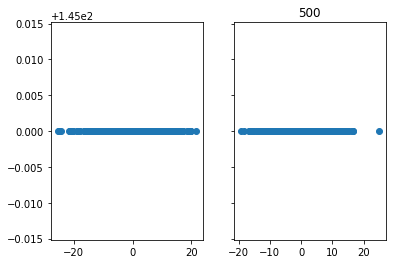

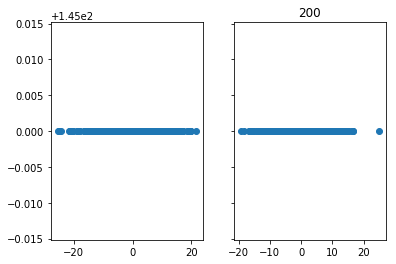

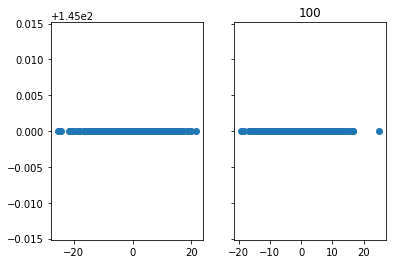

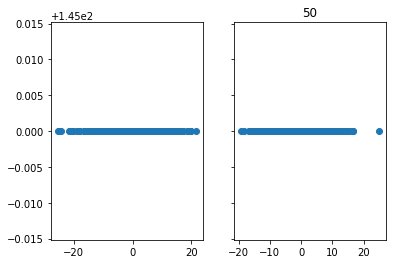

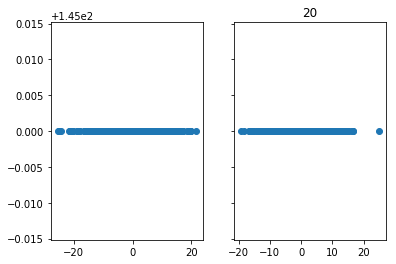

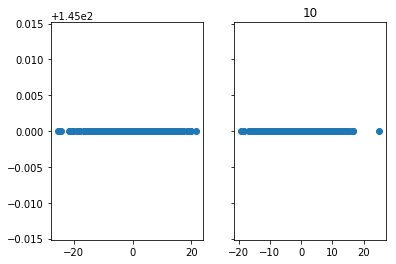

In [115]:
m=RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,n_jobs=-1, oob_score=True)
rf = topsnp_model(m=m,X=X,y=all_meta.residual,val_idx=val_idx)

rf

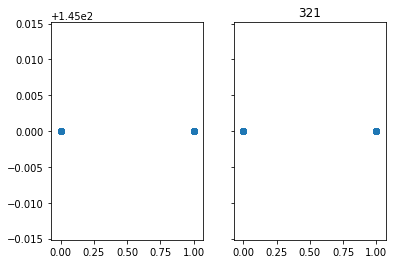

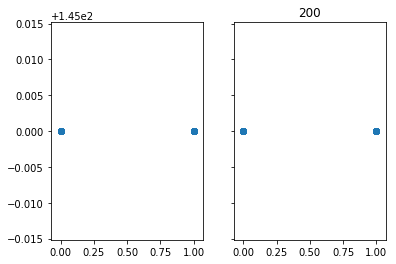

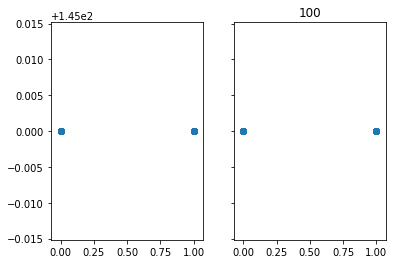

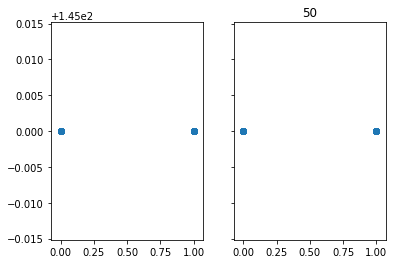

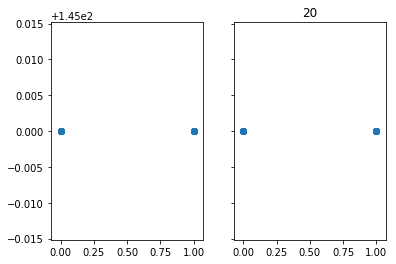

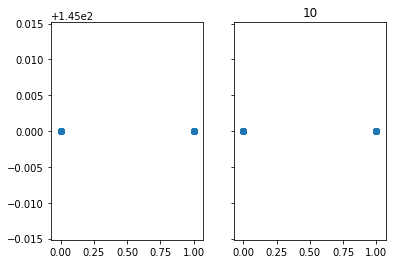

{321: (0.7457507082152974, 0.6543909348441926),
 200: (0.6972379603399433, 0.6175637393767706),
 100: (0.6487252124645893, 0.5949008498583569),
 50: (0.6058781869688386, 0.5708215297450425),
 20: (0.568342776203966, 0.56657223796034),
 10: (0.5559490084985835, 0.5694050991501416)}

In [85]:
tz_f_lg = topsnp_model(m=linear_model.LogisticRegression(),X=X,y=all_meta.biclass,val_idx=val_idx,
                      topn=[321, 200, 100, 50, 20, 10])
tz_f_lg

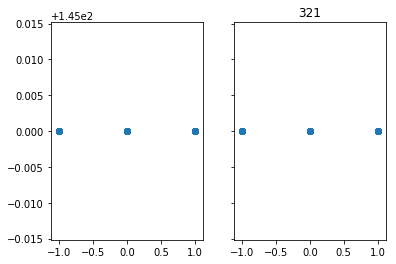

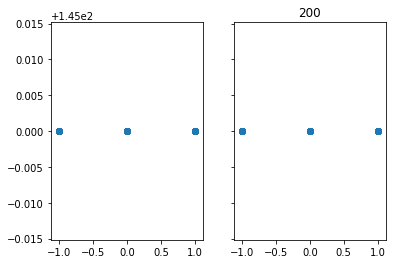

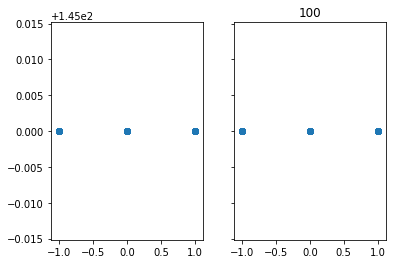

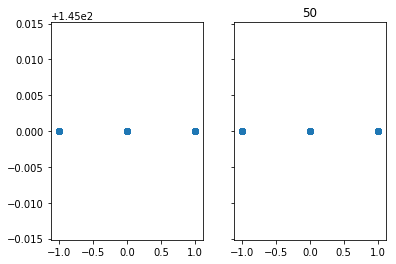

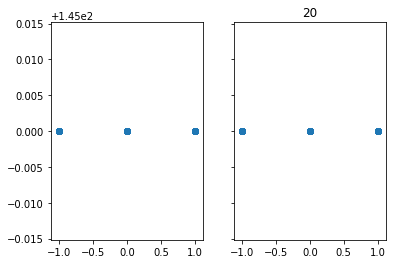

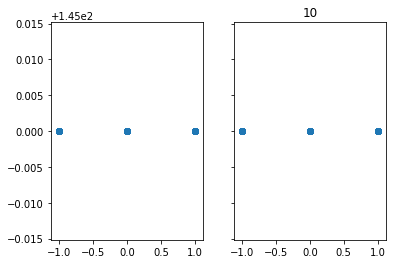

{321: (0.6473087818696884, 0.5),
 200: (0.5991501416430595, 0.48441926345609065),
 100: (0.5428470254957507, 0.4801699716713881),
 50: (0.5339943342776204, 0.4915014164305949),
 20: (0.5226628895184136, 0.5),
 10: (0.5205382436260623, 0.5014164305949008)}

In [86]:
tz_f_lg_triple = topsnp_model(m=linear_model.LogisticRegression(),X=X,y=all_meta.triclass,val_idx=val_idx,
                             topn=[321, 200, 100, 50, 20, 10])
tz_f_lg_triple

## 1.SNPs from the paper

get common genotype with top 10000 list  >>>7726

In [26]:
common_snp = set(snps.snp[0:10000]).intersection(*(tz_bim.snp,os_bim.snp))
len(common_snp)

7726

common snp index in tz and os train data

In [27]:
tz_snp1996_index = [i for i,x in enumerate(tz_bim.snp) if x in common_snp]
os_snp1996_index = [i for i,x in enumerate(os_bim.snp) if x in common_snp]
len(tz_snp1996_index),len(os_snp1996_index)

(7726, 7727)

samples match with meta data

In [41]:
tz_sample_index = [i for i,x in enumerate(tz_fam.iid) if x in list(all_meta.ChipID)]
os_sample_index = [i for i,x in enumerate(os_fam.iid) if int(x) in list(all_meta.ChipID)]
len(tz_sample_index),len(os_sample_index)

(2747, 783)

In [43]:
tz_sub=plink_slice((tz_bim,tz_fam,tz_bed),tz_snp1996_index,tz_sample_index)
os_sub=plink_slice((os_bim,os_fam,os_bed),os_snp1996_index,os_sample_index)

### remove duplicated rs6790793 T A

In [45]:
os_sub[0][os_sub[0].snp.duplicated()],os_sub[0][os_sub[0].snp=='rs6790793'],tz_sub[0][tz_sub[0].snp=='rs6790793']

(        chrom        snp   cm        pos a0 a1        i
 1594752     3  rs6790793  0.0  190918063  T  A  1594752,
         chrom        snp   cm        pos a0 a1        i
 1594751     3  rs6790793  0.0  190918063  C  A  1594751
 1594752     3  rs6790793  0.0  190918063  T  A  1594752,
        chrom        snp   cm        pos a0 a1       i
 174759     3  rs6790793  0.0  190918063  C  A  174759)

In [46]:
os_sub_test[0][os_sub_test[0].snp.duplicated()],os_sub_test[0][os_sub_test[0].snp=='rs6790793']

(        chrom        snp   cm        pos a0 a1        i
 1594752     3  rs6790793  0.0  190918063  T  A  1594752,
         chrom        snp   cm        pos a0 a1        i
 1594751     3  rs6790793  0.0  190918063  C  A  1594751
 1594752     3  rs6790793  0.0  190918063  T  A  1594752)

In [47]:
dup_snp_idx = list(np.where(-os_sub[0].snp.duplicated())[0])

In [48]:
os_sub = plink_slice(os_sub,dup_snp_idx)
os_sub_test=plink_slice(os_sub_test,dup_snp_idx)

In [49]:
print(os_sub_test[0].shape,os_sub[0].shape)
print(os_sub_test[0].iloc[:,0:4].equals(os_sub[0].iloc[:,0:4]))
#but some of them have opposite a0 and a1
sum([x==y for x,y in zip(os_sub_test[0].a0,os_sub[0].a0)])

(7726, 7) (7726, 7)
True


7419

## align a0 and a1 to a ref. (reverse 0 and 2 genotype)

In [51]:
def align_a0_a1(refp,p):
    refbim=refp[0].reset_index(drop=True)
    pbim=p[0].reset_index(drop=True)
    if refbim.snp.equals(pbim.snp) and refbim.pos.equals(pbim.pos):
        diff_idx=[x!=y for x,y in zip(refbim.a0,pbim.a0)]
        if all([x==y for x,y in zip(refbim.a0[diff_idx],pbim.a1[diff_idx])]):
            pbed = pd.DataFrame(p[2].compute())
            tmp = pbed.copy()
            #tmp1 = pbed.copy()
            tmp = tmp.iloc[diff_idx,:]
            #tmp1 = tmp1.iloc[diff_idx,:]
            tmp.replace([0,2],[2,0],inplace=True)
            pbed.loc[diff_idx]=tmp
            return pbed
        else:
            print("can't alignment")
    else:
        print('error happens in align')

align genotype of opensnp traing and test data to taizhao

In [52]:
os_sub_align = align_a0_a1(tz_sub,os_sub)
os_sub_test_align = align_a0_a1(tz_sub,os_sub_test)

In [31]:
os_sub_test_align.to_pickle(TMP_PATH/'os_sub_test_bed_top10000.pk')

## Merge training data from taizhou and opensnp 

In [53]:
all_bim = tz_sub[0]
all_fam = tz_sub[1].append(os_sub[1])
#row sample and column snps
all_bed_T= pd.DataFrame(tz_sub[2].compute()).T.append(os_sub_align.T)
all_bed_T.fillna(-1,inplace=True)
all_bed_T.index = list(all_fam.iid)
all_bed_T.columns=list(all_bim.snp)
all_bim.shape,all_fam.shape,all_bed_T.shape

((7726, 7), (3530, 7), (3530, 7726))

In [97]:
os_sub_test_align_T = os_sub_test_align.T

In [ ]:

os_sub_test_align_T = os_sub_test_align.T
os_sub_test_align_T = os_sub_test_align_T.iloc[:,all_bim_idx]
os_sub_test_align_T.columns = list(common_snp_byp)
#Replace nan values in the training and testing set with an arbitrary number (-1)
os_sub_test_align_T.fillna(-1,inplace=True)

In [61]:
common_index = [i for i,x in enumerate(snps.snp[0:10000]) if x in set(all_bim.snp)]
common_snp_byp=snps.snp[0:10000][common_index]
all_bim_idx=[np.where(x==all_bim.snp)[0][0] for x in common_snp_byp]

In [92]:
all_bim = pd.read_pickle(TMP_PATH/'all_bim_top10000.pk')

In [93]:
all_bim=all_bim.iloc[all_bim_idx,]
all_bed_T = all_bed_T.iloc[:,all_bim_idx]

In [115]:
all_bim.to_pickle(TMP_PATH/'all_bim_top10000.pk')

In [116]:
all_fam.to_pickle(TMP_PATH/'all_fam_top10000.pk')

In [117]:
all_bed_T.to_pickle(TMP_PATH/'all_bed_T_top10000.pk')

In [54]:
all_meta.index = list(all_meta.ChipID)
all_meta=all_meta.loc[all_fam.iid,]

/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [ ]:
all_meta.to_csv(TMP_PATH/'tz_and_os_meta.csv')

In [59]:
tmp = pd.read_csv(TMP_PATH/'tz_and_os_meta.csv',index_col=0)

## 2.SNPs from GWAS of TZ2014

## 3.SNPs from Those Two Source

# Build Model

## Data Prepare

In [10]:
all_bed_T = pd.read_pickle(TMP_PATH/'all_bed_T_top10000.pk')

In [165]:
sum(tmp.astype(np.float32))

783.0

In [276]:
X = all_bed_T
X['gender'] = pd.Series(list(all_meta.gender),index=X.index)
X['nationality'] = pd.Series(list((all_meta.nationality=='PROBLEM').astype(np.int)),index=X.index)
X.fillna(-1,inplace=True)
y = all_meta.height

df_test = os_sub_test_align.T
df_test['gender']=pd.Series(list(os_meta_test.SNPSEX[[int(x) for x in list(os_plink_test[1].iid)]]),index=df_test.index)
df_test['nationality'] = 1
#Replace nan values in the training and testing set with an arbitrary number (-1)
df_test.fillna(-1,inplace=True)

In [277]:
def y_boolean(x,m,f,g):
    if g==1:
        return int(x>m)
    elif g==2:
        return int(x>f)
    else:
        print('error')

m50 = np.percentile(y.loc[list(X.gender==1)],50)
f50 = np.percentile(y.loc[list(X.gender==2)],50)
yb= [y_boolean(x,m50,f50,X.gender.iloc[i]) for i,x in enumerate(y)]

In [234]:
from sklearn.model_selection import cross_val_score
clf = linear_model.Lasso()
scores = cross_val_score(clf, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [235]:
# Predict the heights for the test set
heights = clf.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

NotFittedError: This Lasso instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [233]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_Train, Y_Train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)
clf = linear_model.Lasso()
clf.fit(X_train,y_train)
accuracy = clf.score(X_test,y_test)
print(accuracy)

NameError: name 'cross_validation' is not defined

### Linear model for os data

In [174]:
#Load training data
x_train = X.iloc[2747:3530,]
y_train = y.iloc[2747:3530,]
x_test = df_test

# Instantiate a linear model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : c91fd1c9-9dcc-440d-9959-158b793f250a


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : c91fd1c9-9dcc-440d-9959-158b793f250a


100% |██████████|[00:01<00:00]  100.08% /s] 


CrowdAI.Event.Job.INFO : (c91fd1c9-9dcc-440d-9959-158b793f250a) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -2.2968362511e+19 ; MSE : 2.3348484904e+21
CrowdAI.Event.Job.COMPLETE : c91fd1c9-9dcc-440d-9959-158b793f250a	   🍺 


In [175]:
#Load training data
x_train = X.iloc[2747:3530,]
y_train = y.iloc[2747:3530,]
x_test = df_test

x_train = x_train[['gender','nationality']]
y_train = y_train
x_test = df_test[['gender','nationality']]

# Instantiate a linear model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : ff9496a5-4347-4bca-be34-8213cc3ab7ce


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : ff9496a5-4347-4bca-be34-8213cc3ab7ce


100% |██████████|[00:00<00:00]  103.52% /s] 


CrowdAI.Event.Job.INFO : (ff9496a5-4347-4bca-be34-8213cc3ab7ce) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.420750671304 ; MSE : 58.8835804044
CrowdAI.Event.Job.COMPLETE : ff9496a5-4347-4bca-be34-8213cc3ab7ce	   🍺 


## Sample seperation

3530 2647


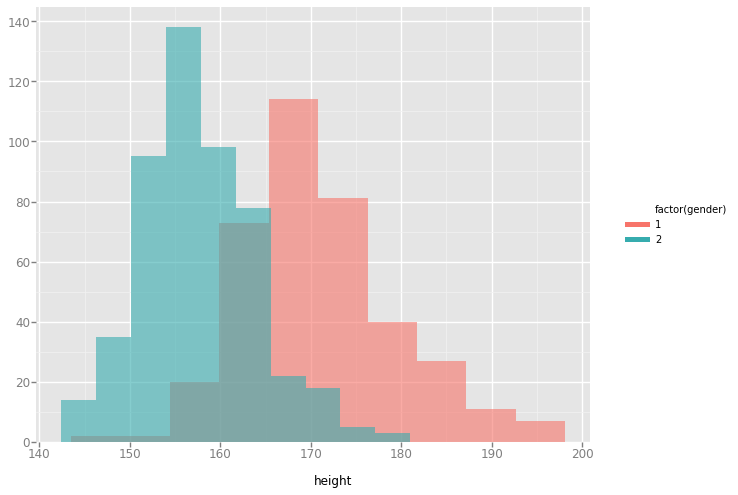

<ggplot: (-9223363300284316977)>

In [272]:
samp_size=len(all_meta)
train_ratio = 0.75
#train_ratio = 0.9
train_size = int(samp_size * train_ratio)

import random
val_idx = random.sample(range(samp_size), samp_size-train_size)
print(samp_size,train_size)
ggplot( aes(x='height',fill='factor(gender)'),data=all_meta.loc[val_idx]) +\
    geom_histogram(alpha=0.6)

## Random Forest

In [282]:
y = np.array(y)

In [283]:
from sklearn.ensemble import RandomForestRegressor
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, y)

m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.99, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [3]:
preds = m.predict(val)

NameError: name 'm' is not defined

In [285]:
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_

(0.8439407662079724, 0.11804699118137751, 0.0804589756030738)

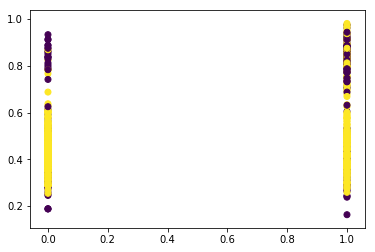

In [286]:
plt.scatter(y_val,preds,c=list(val[:,7726]), marker='o')

In [2]:
heights = m.predict(df_test).tolist()
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

NameError: name 'm' is not defined

## NN1

In [1]:
cat_vars = ['gender','nationality']
contin_vars = X.columns[:-2]

NameError: name 'X' is not defined

In [194]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, X, y.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test,is_reg=False)

In [195]:
cat_sz = [(c, 3) for c in cat_vars]
cat_sz

[('gender', 3), ('nationality', 3)]

In [196]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(3, 2), (3, 2)]

In [197]:
y_range = (130,210)

In [198]:
#m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
#                   0, 1, [256,128,64], [0.3,0.5,0.3], y_range=y_range)

In [213]:
m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
                   0, 1, [128,64,16], [0,0.1,0.1])

In [214]:
lr = 1e-3

In [227]:
m.lr_find()

 43%|████▎     | 9/21 [00:00<00:00, 87.59it/s, loss=46.3]


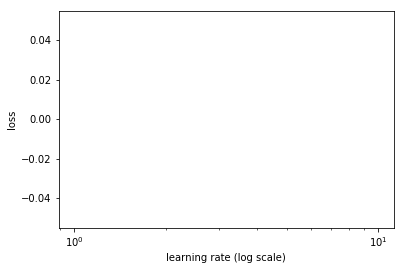

In [228]:
m.sched.plot()

In [229]:
m.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      55.250753  62.687112 
    1      58.415913  64.20576                             
    2      56.39197   62.964787                          



[array([62.96479])]

In [230]:
m.fit(lr, 10, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      56.733091  62.744966 
    1      49.164127  62.002885                            
    2      44.179577  61.256397                          
    3      42.012801  60.872404                            
    4      39.967664  60.322566                          
    5      43.533669  60.629964                            
    6      42.154946  58.021469                          
    7      41.29138   57.008608                          
    8      40.034128  56.676835                          
    9      40.916238  60.169139                            



[array([60.16914])]

In [983]:
m.save('nn_model1') #R2=0.355

 24%|██▍       | 12/50 [00:00<00:00, 119.82it/s, loss=43.2]

epoch      trn_loss   val_loss                             
    0      80.888028  151.194055



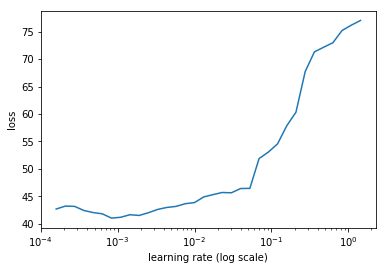

In [984]:
m.lr_find()
m.sched.plot()

In [985]:
m.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss                             
    0      50.995664  42.544632 
    1      43.480691  41.338056                            
    2      42.126355  41.464497                            



[array([41.4645])]

In [1026]:
m.fit(lr, 10, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      57.78584   49.578513 
    1      53.775634  46.085355                            
    2      51.614049  43.825487                            
    3      50.302809  40.732563                            
    4      49.565065  43.737697                           
    5      47.954103  40.983987                            
    6      47.264173  38.763312                          
    7      46.305101  38.572067                            
    8      45.49319   38.968085                            
    9      46.022123  39.092998                            



[array([39.093])]

In [987]:
m.save('nn_model2') #R2=0.436

In [9]:
m.load('nn_model2')

NameError: name 'm' is not defined

In [231]:
# Predict the heights for the test set
heights = m.predict(True)
heights=heights.reshape(137)
heights = heights.tolist()
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : adf40834-afd7-4b4d-bb1d-a0116c14b777


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : adf40834-afd7-4b4d-bb1d-a0116c14b777


100% |██████████|[00:00<00:00]  109.49% /s] 


CrowdAI.Event.Job.INFO : (adf40834-afd7-4b4d-bb1d-a0116c14b777) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.073840333075 ; MSE : 94.1487447856
CrowdAI.Event.Job.COMPLETE : adf40834-afd7-4b4d-bb1d-a0116c14b777	   🍺 


## NN2

In [972]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(y)
y_range = (140,200)

In [317]:
maf=pd.read_csv('../predict_height/lib/maf.csv',index_col=0)

In [321]:
sum([x in maf.index for x in all_bim.snp])

628

In [792]:
# Instantiate a linear model
x_train=X
y_train=y
x_test=df_test
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)

In [793]:
#Convert heights from np.array to a list (to ensure it is JSON serializable)
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")

heights = heights.tolist()
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[16:49<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : bc1ef311-9598-4a6c-a9a2-cce75662d779



          
  0% |          |[16:49<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : bc1ef311-9598-4a6c-a9a2-cce75662d779



          
  0% |          |[16:49<?]  ?% /s] 
100% |██████████|[00:00<00:00]  102.69% /s] 
          
  0% |          |[16:49<?]  ?% /s] .69% /s] 


CrowdAI.Event.Job.INFO : (bc1ef311-9598-4a6c-a9a2-cce75662d779) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.0365818509984 ; MSE : 105.373709981
CrowdAI.Event.Job.COMPLETE : bc1ef311-9598-4a6c-a9a2-cce75662d779	   🍺 


In [ ]:
import preprocess
import argparse
import models


def init_args():
    parser = argparse.ArgumentParser(description='Train and save models')
    parser.add_argument('train_datesets', help='Input csv file for training output from parse_inputs.py')
    parser.add_argument('-m', '--model', help='Train model, comma to separate', default='gbr')
    parser.add_argument('-d', '--model-dir', help='Model directory', default='models')
    parser.add_argument('-l', '--list-models', help='List available models', action='store_true')
    args = parser.parse_args()
    return args


def main():
    args = init_args()
    if args.list_models:
        print('\n'.join(models.get_model_names()))
        exit()
    m = args.model.split(',')
    dict_m = models.get_models(m)
    x, y = preprocess.load_data(args.train_datesets)
    for model_name in dict_m:
        model = dict_m[model_name]
        print('Training model %s' % model_name)
        model.fit(x, y)
        models.save_model(model, model_name, args.model_dir)
        print('Train finished, save to %s' % args.model_dir)

